In [21]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.data import Collector, VectorReplayBuffer
from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.trainer import offpolicy_trainer
from LCRL.utils import TensorboardLogger
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic, ActorProb
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

# NOTE: This notebook is used after training the reach-avoid value function via SAC

"""
    We can also learn the classical reach-avoid value function by using SAC under the classical annealed reach-avoid Bellman equation in arXiv:2112.12288:
    python run_training_sac.py --task ra_droneracing_Game-v6 --control-net 512 512 512 512 --disturbance-net 512 512 512 512 --critic-net 512 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160 --is-game-baseline True
"""

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_droneracing_Game-v6')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.0)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512]*4) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512]*4) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512]*4) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=False) # True -> annealed reach-avoid Bellman equation, False -> our new reach-rl Bellman equation
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    parser.add_argument('--warm-start-path', type=str, default=None)
    # new sac params:
    parser.add_argument('--alpha', default = 0.2) 
    parser.add_argument('--auto-alpha', type=int, default=1)
    parser.add_argument('--alpha-lr', type=float, default=3e-4)
    args = parser.parse_known_args()[0]
    return args



args=get_args()


env = gym.make(args.task)
# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

args.action1_shape = env.action1_space.shape or env.action1_space.n
args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
args.max_action2 = env.action2_space.high[0]



train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    # report error:
    raise ValueError("Please provide critic_net!")

# critic = Critic(critic_net, device=args.device).to(args.device)
# critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
# import pdb; pdb.set_trace()
log_path = None

if args.is_game_baseline:
    from LCRL.policy import reach_avoid_game_SACPolicy_annealing as SACPolicy
    print("SAC under the Reach-Avoid annealed Bellman equation has been loaded!")
else:
    from LCRL.policy import reach_avoid_game_SACPolicy as SACPolicy
    print("SAC under the Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = ActorProb(
    actor1_net, 
    args.action1_shape, 
    device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
actor2 = ActorProb(
    actor2_net, 
    args.action2_shape, 
    device=args.device
).to(args.device)
actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)
if args.auto_alpha:
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
    args.alpha = (target_entropy, log_alpha, alpha_optim)

policy = SACPolicy(
critic1,
critic1_optim,
critic2,
critic2_optim,
tau=args.tau,
gamma=args.gamma,
alpha = args.alpha,
exploration_noise= None,#GaussianNoise(sigma=args.exploration_noise), # careful!
deterministic_eval = True,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor2=actor2,
actor2_optim=actor2_optim,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, always true
    args.gamma)
    )
else:
    log_path = os.path.join(args.logdir, args.task, 'sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, # always true
    args.gamma)
    )

log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



SAC under the Reach-RL Bellman equation has been loaded!


In [26]:
# data reloading module:
epoch_id = 20
envs = gym.make(args.task)
# check if the log path exists
# NOTE! You can define the log path in next line:
# log_path = ""

if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")



policy loaded!


In [3]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [27]:
from LCRL.data import Batch
def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from tqdm import tqdm

  0%|          | 0/260 [00:00<?, ?it/s]/tmp/ipykernel_24162/2624877537.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 260/260 [01:02<00:00,  4.14it/s]


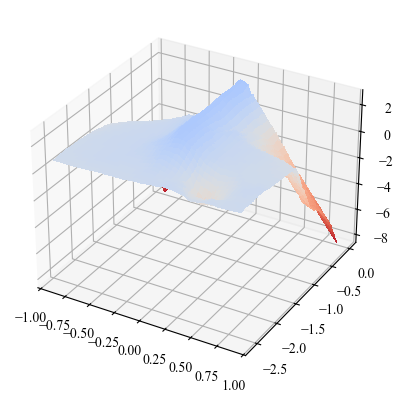

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'

x = np.arange(-0.9, 0.9, 0.01)
y = np.arange(-2.6, -0., 0.01)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))
ego_vx = 0.0
ego_vy = 0.7 # previous 0.8
ego_z = 0.0
ego_vz = 0.0


ad_x = 0.4
ad_vx = 0.0
ad_y = -2.2
ad_vy = 0.3
ad_z = 0.0
ad_vz = 0.0

X_V = X
Y_V = Y
for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            X[ii,jj], ego_vx,
            Y[ii,jj], ego_vy,
            ego_z, ego_vz,
            ad_x,  ad_vx,
            ad_y, ad_vy,
            ad_z, ad_vz
        ])
        V[ii,jj] = evaluate_V( tmp_point )
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,vmin= V.min(), vmax=-V.min(),
                        linewidth=0, antialiased=False)

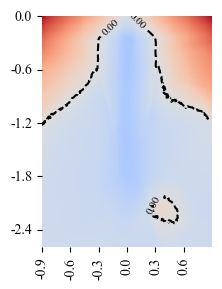

In [29]:
import seaborn as sns

x_interval = 30
y_interval = 60

fig, ax = plt.subplots(figsize=(2.2, 3))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax, vmin= V_flipped.min(), vmax=-V_flipped.min(),
            cbar=False,
            )

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+0.02, 1))

contours = ax.contour((X+0.9)*100, (Y+2.6)*100, V_flipped, levels=[0], colors="black", linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [60]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1
